In [1]:
import math
import os
from datetime import datetime, timedelta
from typing import Tuple, Callable, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import talib
from random import random, seed
from bot.book import Limit, PlaceOrder, order_processor_setup, place_bet, order_price

In [2]:
def random_walker(data_length: int):
    #seed(1)
    random_walk = list()
    random_walk.append(-1 if random() < 0.5 else 1)
    for i in range(0, data_length):
        movement = -1 if random() < 0.5 else 1
        value = random_walk[i] + movement
        random_walk.append(value)
    return random_walk

In [3]:
def load_data(filename: str, offset: float, variance: float):
    if not os.path.exists(filename):
        prob = [0.05, 0.95]
        data_length = 1000
        positions = random_walker(data_length)

        date_today = datetime.now()
        minutes = pd.date_range(date_today, date_today + timedelta(0, 60 * data_length), freq='min')
        data = pd.DataFrame({'Coin1': positions}, index = minutes )
        data["Coin1"] = offset + data["Coin1"] * variance
        data.to_pickle(filename)
    else:
        data = pd.read_pickle(filename)
    
    # plotting down the graph of the random walk in 1D
    plt.plot(data.to_numpy())
    plt.show()

    return data

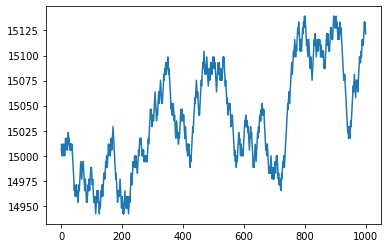

In [10]:
price_trend = load_data("test_trend.pickle", 15000, 5.8)

In [11]:
print(price_trend['Coin1'].to_numpy())
price_trend.dtypes

[15005.8 15011.6 15005.8 ... 15133.4 15127.6 15121.8]


Coin1    float64
dtype: object

In [22]:
def order_amount_simple(credit: float, price: float, prediction):
    """Returns a simple function to calculate the amount to trade"""
    def amount(predicted: float, price: float):
        return (credit * predicted) / price

    return place_bet(*prediction)(price, amount)

In [13]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [14]:
def simple_analyzer(trend: List[float], buy_limit: float, sell_limit: float, purchased_price: float,
                    moving_average_windows: int, rsi_window: int) -> Tuple[float, float]:
    """Returns a simple and static price trend course prediction"""
    # pylint: disable=unused-argument
    moving_avg = moving_average(trend, moving_average_windows)[-1]
    rsi = talib.RSI(trend, timeperiod=rsi_window)[-1]
    price = trend[-1]
    print("RSI :{}, moving average: {}".format(rsi, moving_avg))
    if math.isnan(moving_avg) is False and math.isnan(rsi) is False:
        # check buy condition
        if price < (moving_avg - (moving_avg * buy_limit)) and (rsi <= 39.5):
            return 0.1, 0.9
        # check sell conditions
        if price > (purchased_price + (purchased_price * sell_limit)):
            return 0.9, 0.1

    return 0, 0

In [25]:
credit: float = 1000
price_curve_coin1 = price_trend["Coin1"].to_numpy()
prediction = simple_analyzer(price_curve_coin1, 0.0075, .02, 14500, 24, 48)
print(prediction)
print('prediction: => sell: {}, buy: {}'.format(prediction[0], prediction[1]))
print('price: {}'.format(price_curve_coin1[-1]))
order = order_amount_simple(credit, price_curve_coin1[-1], prediction)
print(order)
credit = order_price(order, credit)
print(credit)

RSI :55.80611904498788, moving average: 15109.233333333332
(0.9, 0.1)
prediction: => sell: 0.9, buy: 0.1
price: 15121.8
PlaceOrder(type='sell', amount=0.05951672419950006, price=15121.8, timestamp=datetime.datetime(2021, 1, 30, 1, 25, 59, 816174, tzinfo=datetime.timezone.utc))
1900.0


In [ ]:
rsi = talib.RSI(price_trend["Coin1"].to_numpy(), timeperiod=48)
plt.plot(rsi)
plt.show()